In [1]:
## Workflow

# INPUT -> Research Node -> Paragraph Generator -> Outline Generator -> Human Approval -> Paragraph generator -> Style Selection -> Output

In [171]:
import os 
from dotenv import load_dotenv 
load_dotenv()

True

In [172]:
from langgraph.graph import StateGraph,START,END 
from typing import TypedDict,Annotated
from langgraph.graph.message import add_messages 
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_groq import ChatGroq 
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.types import Command,interrupt
from langgraph.checkpoint.memory import MemorySaver

In [173]:
memory = MemorySaver()

In [346]:
class BlogState(TypedDict):
    messages : Annotated[list,add_messages]
    blog_title: str
    research_notes: str
    outline: str
    approved: bool
    
    style: str 
    styled_output : str 

In [347]:
workflow = StateGraph(BlogState)

In [348]:
# defining the nodes 






research_tool = TavilySearchResults(max_results=3)

research_llm = ChatGroq(model="gemma2-9b-It")



def research_node(state: BlogState):
    research_prompt = f"""You are a research assistant helping to write a blog on the topic: "{state['blog_title']}".
    
    Find key facts, statistics, recent developments, and important points related to this topic.
    Keep it relevant for a blog article. Present your findings as clear, concise bullet points.

    Use the Tavily search tool provided to conduct the research."""

    runnable = research_llm.bind_tools(tools=[research_tool])

    response = runnable.invoke(research_prompt)

  
    

    return {
        "research_notes": response.content,
        "messages": state["messages"] + [HumanMessage(content=research_prompt), response]
    }

   


In [349]:
tools = ToolNode(tools=[research_tool])

In [350]:

generator_llm = ChatGroq(model="gemma2-9b-It")

def outline_generator(state:BlogState):
    outline_prompt = f"""You are an expert blog writer.

Based on the following research notes, generate a well-structured blog outline for the topic: "{state['blog_title']}".
\n
Research Notes:
{state['research_notes']}

The outline should be engaging, logically organized, and suitable for a blog article. Include 4–6 main sections, each with a short, clear heading. Ensure the outline flows naturally and covers the key points from the research.
"""
    
    result = generator_llm.invoke(outline_prompt)

    return {"outline" : result.content,"messages" : [result]} 


In [351]:
def research_condition(state):
    """Custom condition function that works with your state structure"""
    # Check if research_notes indicates tools were used
    research_notes = state.get("research_notes", "")
    
    # If research_notes is empty, we might need to use tools
    if not research_notes or research_notes.strip() == "":
        return "research_tools"
    else:
        return "outline_generator"

In [352]:
# approve the outline from human

def human_approval(state: BlogState) :
    # Pause the graph and ask for human input
    is_approved = interrupt({
        "question": "Do you approve this outline for the blog?",
        "outline": state["outline"],
        "blog_title": state["blog_title"]
    })

    # Update the `approved` field in the state
    updated_state = {
        **state,
        "approved": is_approved
    }

    # Route based on approval
    if is_approved:
        return Command(goto="style_selector", update=updated_state)
    else:
        return Command(goto="outline_generator", update=updated_state)





In [353]:
def approval_condition(state: BlogState):
    return "style_selector" if state["approved"] else "outline_generator"

In [354]:

workflow.add_node("research_node",research_node)
workflow.add_node("research_tools",tools)  # ToolNode
workflow.add_node("outline_generator",outline_generator)
workflow.add_node("human_approval",human_approval)


workflow.add_edge(START,"research_node")


workflow.add_conditional_edges(
    "research_node",
    research_condition,
    {
        "research_tools": "research_tools",        # When tools are called
        "outline_generator": "outline_generator"    # When no tools are called
    }
)

workflow.add_edge("research_tools","research_node")
workflow.add_edge("research_node","outline_generator")
workflow.add_edge("outline_generator","human_approval")

workflow.add_conditional_edges(
    "human_approval",
    approval_condition,
    {
        "style_selector": END,         # If approved
        "outline_generator": "outline_generator"    # If rejected
    }
)

workflow.add_edge("human_approval",END)


In [355]:
graph = workflow.compile(checkpointer=memory)


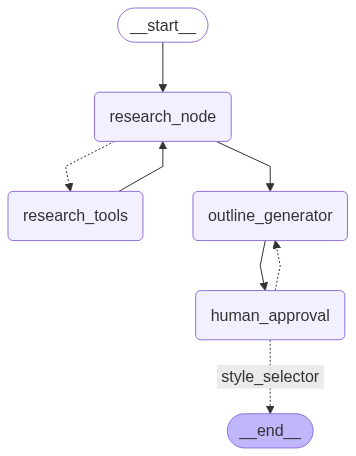

In [356]:
from IPython.display import Image,display 

image = display(Image(graph.get_graph().draw_mermaid_png()))

In [357]:
config = {"configurable"  : {
    "thread_id" : "abc"
}}

In [358]:
result = graph.invoke({
    "blog_title": "Latest developments in AI",
    "research_notes": "",
    "outline": "",
    "approved": False,
    "style": "professional",
    "styled_output": "",
    "messages": [HumanMessage(content="Write a blog on Latest developments in AI")]
}, config=config)

In [359]:
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'e1v7yg1g6', 'function': {'arguments': '{"query":"Recent developments in NVIDIA STOCKS"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1059, 'total_tokens': 1151, 'completion_time': 0.167272727, 'prompt_time': 0.022363208, 'queue_time': 0.25816464299999997, 'total_time': 0.189635935}, 'model_name': 'gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1a178711-1d4d-4532-a2d3-e34ee3e84fb2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Recent developments in NVIDIA STOCKS'}, 'id': 'e1v7yg1g6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1059, 'output_tokens': 92, 'total_tokens': 1151}),
  HumanMessage(content='Write a blog on Latest developments in NVIDIA Stocks', additional_kwargs={}, response

In [362]:
result['messages']

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'e1v7yg1g6', 'function': {'arguments': '{"query":"Recent developments in NVIDIA STOCKS"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1059, 'total_tokens': 1151, 'completion_time': 0.167272727, 'prompt_time': 0.022363208, 'queue_time': 0.25816464299999997, 'total_time': 0.189635935}, 'model_name': 'gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1a178711-1d4d-4532-a2d3-e34ee3e84fb2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Recent developments in NVIDIA STOCKS'}, 'id': 'e1v7yg1g6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1059, 'output_tokens': 92, 'total_tokens': 1151}),
 HumanMessage(content='Write a blog on Latest developments in NVIDIA Stocks', additional_kwargs={}, response_metadata={}, 

In [156]:
result = graph.invoke(
    {"approved": False},  # 👈 or False if rejected
    config={"configurable": {"thread_id": "abc"}}
)

In [157]:
result

{'messages': [AIMessage(content="**Outline: Latest Developments in NVIDIA Stocks**\n\n---\n\n**1. Introduction: NVIDIA's Meteoric Rise**  \n- Brief overview of NVIDIA’s position in the tech industry  \n- Recent headlines and investor buzz around NVIDIA stocks  \n- Purpose: Unpacking what’s behind NVIDIA’s current stock performance\n\n---\n\n**2. Record-Breaking Financial Performance**  \n- Recap of NVIDIA’s latest quarterly earnings  \n- Revenue, profit margins, and EPS growth compared to previous years  \n- Key drivers: Data center demand, AI chip sales, and gaming segment rebound\n\n---\n\n**3. The AI Boom: Fueling NVIDIA’s Value**  \n- How the generative AI wave impacts demand for NVIDIA products  \n- Major partnerships and customers in AI/cloud computing  \n- Competitive advantage: CUDA software & proprietary chip architecture  \n\n---\n\n**4. Stock Price Surge and Market Capitalization**  \n- Recent stock price milestones and growth versus tech peers  \n- NVIDIA’s entry into the “

In [159]:
state = graph.get_state(config)

In [169]:
state.values

{'messages': [AIMessage(content="**Outline: Latest Developments in NVIDIA Stocks**\n\n---\n\n**1. Introduction: NVIDIA's Meteoric Rise**  \n- Brief overview of NVIDIA’s position in the tech industry  \n- Recent headlines and investor buzz around NVIDIA stocks  \n- Purpose: Unpacking what’s behind NVIDIA’s current stock performance\n\n---\n\n**2. Record-Breaking Financial Performance**  \n- Recap of NVIDIA’s latest quarterly earnings  \n- Revenue, profit margins, and EPS growth compared to previous years  \n- Key drivers: Data center demand, AI chip sales, and gaming segment rebound\n\n---\n\n**3. The AI Boom: Fueling NVIDIA’s Value**  \n- How the generative AI wave impacts demand for NVIDIA products  \n- Major partnerships and customers in AI/cloud computing  \n- Competitive advantage: CUDA software & proprietary chip architecture  \n\n---\n\n**4. Stock Price Surge and Market Capitalization**  \n- Recent stock price milestones and growth versus tech peers  \n- NVIDIA’s entry into the “